## Importing Libraries

In [52]:
%matplotlib inline

import pandas as pd # For DataFrames, Series, and reading csv data in.
import seaborn as sns # Graphing, built ontop of MatPlot for ease-of-use and nicer diagrams.
import matplotlib.pyplot as plt # MatPlotLib for graphing data visually. Seaborn more likely to be used.
import numpy as np # For manipulating arrays and changing data into correct formats for certain libraries
import sklearn # For Machine Learning algorithms
import scikitplot # Confusion matrix plotting

from sklearn.decomposition import PCA # For PCA dimensionality reduction technique
from sklearn.preprocessing import StandardScaler # For scaling to unit scale, before PCA application
from sklearn.preprocessing import LabelBinarizer # For converting categorical data into numeric, for modeling stage
from sklearn.model_selection import StratifiedKFold # For optimal train_test splitting, for model input data
from sklearn.model_selection import train_test_split # For basic dataset splitting
from sklearn.neighbors import KNeighborsClassifier # K-Nearest Neighbors ML classifier (default n. of neighbors = 5)

from scikitplot.metrics import plot_confusion_matrix # For plotting confusion matrices
from sklearn.metrics import accuracy_score # For getting the accuracy of a model's predictions
from sklearn.metrics import classification_report # Various metrics for model performance
from sklearn.neural_network import MLPClassifier # For Neural Network classifier
from sklearn.linear_model import LogisticRegression

### clean_dataset()

In [53]:
def clean_dataset(df):
    assert isinstance(df, pd.DataFrame), "df needs to be a pd.DataFrame"
    df.dropna(inplace=True)
    indices_to_keep = ~df.isin([np.nan, np.inf, -np.inf]).any(1)
    return df[indices_to_keep]

### get_PCA_feature_names()

In [54]:
def get_PCA_feature_names(num_of_pca_components):
    feature_names = []
    for i in range(num_of_pca_components):    
        feature_names.append(f"Principal component {i+1}")
    return feature_names

### train_model_predict()

In [55]:
def train_model_predict(model, model_name, X, y, skf):
    for train_index, test_index in skf.split(X, y): # 1)
        X_train, X_test = X.iloc[train_index], X.iloc[test_index] # 2)
        y_train, y_test = y.iloc[train_index], y.iloc[test_index]

        reshaped_y_train = np.asarray(y_train).reshape(-1, 1) # 3)
        reshaped_y_test = np.asarray(y_test).reshape(-1, 1)
        
    model.fit(X_train, reshaped_y_train.ravel()) # 4)
    pred_y = model.predict(X_test) # 5)
    score = classification_report(reshaped_y_test, pred_y) # 6)
    print('Classification report: \n', score, '\n')
    plot_confusion_matrix(reshaped_y_test, pred_y, title='Confusion Matrix for {}'.format(model_name))
        
    return accuracy_score(reshaped_y_test, pred_y), X_train, X_test, y_train, pred_y

### get_shuffled_stratifiedKFold_train_test_split()

In [56]:
def get_shuffled_stratifiedKFold_train_test_split(X, y):
    # Shuffle to True, to get different shuffles each time. Permutations being varied is the goal here.
    skf = StratifiedKFold(n_splits=3, shuffle=True)
    
    # For loop to get index for training and test data, using StratifiedKFold (3 splits)
    for train_index, test_index in skf.split(X, y):
        X_train, X_test = X.iloc[train_index], X.iloc[test_index]
        y_train, y_test = y.iloc[train_index], y.iloc[test_index]
        
    return X_train, X_test, y_train, y_test

### Useful environment variables

In [57]:
# 'Reduced dimensions' variable for altering the number of PCA principal components. Can be altered for needs.
# Only 7 principal components needed when using non-normalised PCA dataset.
dimensions_num_for_PCA = 7

# Max number of permutations to run. Can be altered for needs.
number_of_permutations = 100

# 10 folds is usually the heuristic to follow for larger datasets of around this size.
num_of_splits_for_skf = 10

# Code starting point

In [58]:
Friday_Morning_Data = pd.read_csv('Friday-WorkingHours-Afternoon-PortScan.pcap_ISCX.csv')
df = Friday_Morning_Data.copy()
df.head()

,Destination Port,Flow Duration,Total Fwd Packets,Total Backward Packets,Total Length of Fwd Packets,Total Length of Bwd Packets,Fwd Packet Length Max,Fwd Packet Length Min,Fwd Packet Length Mean,Fwd Packet Length Std,...,min_seg_size_forward,Active Mean,Active Std,Active Max,Active Min,Idle Mean,Idle Std,Idle Max,Idle Min,Label
0,22,1266342,41,44,2664,6954,456,0,64.975610,109.864573,...,32,0.0,0.0,0,0,0.0,0.0,0,0,BENIGN
1,22,1319353,41,44,2664,6954,456,0,64.975610,109.864573,...,32,0.0,0.0,0,0,0.0,0.0,0,0,BENIGN
2,22,160,1,1,0,0,0,0,0.000000,0.000000,...,32,0.0,0.0,0,0,0.0,0.0,0,0,BENIGN
3,22,1303488,41,42,2728,6634,456,0,66.536585,110.129945,...,32,0.0,0.0,0,0,0.0,0.0,0,0,BENIGN
4,35396,77,1,2,0,0,0,0,0.000000,0.000000,...,32,0.0,0.0,0,0,0.0,0.0,0,0,BENIGN


In [59]:
df.shape

(286467, 79)

# Data Preparation stage

### Fixing column name issues

* **str.strip()** just strips/ removes any leading and trailing spaces
* **str.lower()** just converts all characters to lower case
* **str.replace('x', 'y')** just replaces all instances of x with y, i.e. changing spaces to '_'
* **str.replace('x', '')** can be used to remove the specified x characters (replacing with nothing/ empty char)

In [60]:
df.columns = df.columns.str.strip().str.lower().str.replace(' ', '_').str.replace('(', '').str.replace(')', '')
df.head()

,destination_port,flow_duration,total_fwd_packets,total_backward_packets,total_length_of_fwd_packets,total_length_of_bwd_packets,fwd_packet_length_max,fwd_packet_length_min,fwd_packet_length_mean,fwd_packet_length_std,...,min_seg_size_forward,active_mean,active_std,active_max,active_min,idle_mean,idle_std,idle_max,idle_min,label
0,22,1266342,41,44,2664,6954,456,0,64.975610,109.864573,...,32,0.0,0.0,0,0,0.0,0.0,0,0,BENIGN
1,22,1319353,41,44,2664,6954,456,0,64.975610,109.864573,...,32,0.0,0.0,0,0,0.0,0.0,0,0,BENIGN
2,22,160,1,1,0,0,0,0,0.000000,0.000000,...,32,0.0,0.0,0,0,0.0,0.0,0,0,BENIGN
3,22,1303488,41,42,2728,6634,456,0,66.536585,110.129945,...,32,0.0,0.0,0,0,0.0,0.0,0,0,BENIGN
4,35396,77,1,2,0,0,0,0,0.000000,0.000000,...,32,0.0,0.0,0,0,0.0,0.0,0,0,BENIGN


In [61]:
df.label.value_counts()

PortScan    158930
BENIGN      127537
Name: label, dtype: int64

### Looking at the original data types

In [62]:
df.dtypes

destination_port                 int64
flow_duration                    int64
total_fwd_packets                int64
total_backward_packets           int64
total_length_of_fwd_packets      int64
                                ...   
idle_mean                      float64
idle_std                       float64
idle_max                         int64
idle_min                         int64
label                           object
Length: 79, dtype: object

### Fixing issues with ScikitLearn's PCA transform on this dataset

In [63]:
df_cleaned = df.copy()
df_cleaned = clean_dataset(df_cleaned) # see methods at top of notebook
df_cleaned

,destination_port,flow_duration,total_fwd_packets,total_backward_packets,total_length_of_fwd_packets,total_length_of_bwd_packets,fwd_packet_length_max,fwd_packet_length_min,fwd_packet_length_mean,fwd_packet_length_std,...,min_seg_size_forward,active_mean,active_std,active_max,active_min,idle_mean,idle_std,idle_max,idle_min,label
0,22,1266342,41,44,2664,6954,456,0,64.975610,109.864573,...,32,0.0,0.0,0,0,0.0,0.0,0,0,BENIGN
1,22,1319353,41,44,2664,6954,456,0,64.975610,109.864573,...,32,0.0,0.0,0,0,0.0,0.0,0,0,BENIGN
2,22,160,1,1,0,0,0,0,0.000000,0.000000,...,32,0.0,0.0,0,0,0.0,0.0,0,0,BENIGN
3,22,1303488,41,42,2728,6634,456,0,66.536585,110.129945,...,32,0.0,0.0,0,0,0.0,0.0,0,0,BENIGN
4,35396,77,1,2,0,0,0,0,0.000000,0.000000,...,32,0.0,0.0,0,0,0.0,0.0,0,0,BENIGN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
286462,443,196135,49,57,1331,105841,570,0,27.163265,108.067176,...,20,0.0,0.0,0,0,0.0,0.0,0,0,BENIGN
286463,443,378424,49,59,1325,104393,570,0,27.040816,108.095051,...,20,0.0,0.0,0,0,0.0,0.0,0,0,BENIGN
286464,443,161800,70,103,1427,215903,570,0,20.385714,90.746389,...,20,0.0,0.0,0,0,0.0,0.0,0,0,BENIGN
286465,443,142864,50,62,1331,110185,570,0,26.620000,107.027727,...,20,0.0,0.0,0,0,0.0,0.0,0,0,BENIGN


In [64]:
df_cleaned = df_cleaned.reset_index()
# Removing un-needed index column added by reset_index method
df_cleaned.drop('index', axis=1, inplace=True)
df_cleaned

,destination_port,flow_duration,total_fwd_packets,total_backward_packets,total_length_of_fwd_packets,total_length_of_bwd_packets,fwd_packet_length_max,fwd_packet_length_min,fwd_packet_length_mean,fwd_packet_length_std,...,min_seg_size_forward,active_mean,active_std,active_max,active_min,idle_mean,idle_std,idle_max,idle_min,label
0,22,1266342,41,44,2664,6954,456,0,64.975610,109.864573,...,32,0.0,0.0,0,0,0.0,0.0,0,0,BENIGN
1,22,1319353,41,44,2664,6954,456,0,64.975610,109.864573,...,32,0.0,0.0,0,0,0.0,0.0,0,0,BENIGN
2,22,160,1,1,0,0,0,0,0.000000,0.000000,...,32,0.0,0.0,0,0,0.0,0.0,0,0,BENIGN
3,22,1303488,41,42,2728,6634,456,0,66.536585,110.129945,...,32,0.0,0.0,0,0,0.0,0.0,0,0,BENIGN
4,35396,77,1,2,0,0,0,0,0.000000,0.000000,...,32,0.0,0.0,0,0,0.0,0.0,0,0,BENIGN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
286091,443,196135,49,57,1331,105841,570,0,27.163265,108.067176,...,20,0.0,0.0,0,0,0.0,0.0,0,0,BENIGN
286092,443,378424,49,59,1325,104393,570,0,27.040816,108.095051,...,20,0.0,0.0,0,0,0.0,0.0,0,0,BENIGN
286093,443,161800,70,103,1427,215903,570,0,20.385714,90.746389,...,20,0.0,0.0,0,0,0.0,0.0,0,0,BENIGN
286094,443,142864,50,62,1331,110185,570,0,26.620000,107.027727,...,20,0.0,0.0,0,0,0.0,0.0,0,0,BENIGN


In [65]:
df_cleaned.shape

(286096, 79)

### Considerations before PCA can be used correctly (before Data Preparation feature selection via PCA)

##### What features should be included from PCA, and why?
* **df.columns.tolist()** converts the Dataframe column names into a Python list

In [66]:
df.columns.tolist()

['destination_port',
 'flow_duration',
 'total_fwd_packets',
 'total_backward_packets',
 'total_length_of_fwd_packets',
 'total_length_of_bwd_packets',
 'fwd_packet_length_max',
 'fwd_packet_length_min',
 'fwd_packet_length_mean',
 'fwd_packet_length_std',
 'bwd_packet_length_max',
 'bwd_packet_length_min',
 'bwd_packet_length_mean',
 'bwd_packet_length_std',
 'flow_bytes/s',
 'flow_packets/s',
 'flow_iat_mean',
 'flow_iat_std',
 'flow_iat_max',
 'flow_iat_min',
 'fwd_iat_total',
 'fwd_iat_mean',
 'fwd_iat_std',
 'fwd_iat_max',
 'fwd_iat_min',
 'bwd_iat_total',
 'bwd_iat_mean',
 'bwd_iat_std',
 'bwd_iat_max',
 'bwd_iat_min',
 'fwd_psh_flags',
 'bwd_psh_flags',
 'fwd_urg_flags',
 'bwd_urg_flags',
 'fwd_header_length',
 'bwd_header_length',
 'fwd_packets/s',
 'bwd_packets/s',
 'min_packet_length',
 'max_packet_length',
 'packet_length_mean',
 'packet_length_std',
 'packet_length_variance',
 'fin_flag_count',
 'syn_flag_count',
 'rst_flag_count',
 'psh_flag_count',
 'ack_flag_count',
 'ur

### Data Preparation: PCA Dimension reduction and scaling (Hughes' Phenomenon)

In [67]:
# Saving the label attribute before dropping it.
df_labels = df_cleaned['label']
# Shows all the possible labels/ classes a model can predict.
# Need to alter these to numeric 0, 1, etc... for model comprehension (e.g. pd.get_dummies()).
df_labels.unique()

array(['BENIGN', 'PortScan'], dtype=object)

In [68]:
# Axis=1 means columns. Axis=0 means rows. inplace=False means that the original 'df' isn't altered.
df_no_labels = df_cleaned.drop('label', axis=1, inplace=False)
# Getting feature names for the StandardScaler process
df_features = df_no_labels.columns.tolist()
# Printing out Dataframe with no label column, to show successful dropping
df_no_labels

,destination_port,flow_duration,total_fwd_packets,total_backward_packets,total_length_of_fwd_packets,total_length_of_bwd_packets,fwd_packet_length_max,fwd_packet_length_min,fwd_packet_length_mean,fwd_packet_length_std,...,act_data_pkt_fwd,min_seg_size_forward,active_mean,active_std,active_max,active_min,idle_mean,idle_std,idle_max,idle_min
0,22,1266342,41,44,2664,6954,456,0,64.975610,109.864573,...,24,32,0.0,0.0,0,0,0.0,0.0,0,0
1,22,1319353,41,44,2664,6954,456,0,64.975610,109.864573,...,24,32,0.0,0.0,0,0,0.0,0.0,0,0
2,22,160,1,1,0,0,0,0,0.000000,0.000000,...,0,32,0.0,0.0,0,0,0.0,0.0,0,0
3,22,1303488,41,42,2728,6634,456,0,66.536585,110.129945,...,24,32,0.0,0.0,0,0,0.0,0.0,0,0
4,35396,77,1,2,0,0,0,0,0.000000,0.000000,...,0,32,0.0,0.0,0,0,0.0,0.0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
286091,443,196135,49,57,1331,105841,570,0,27.163265,108.067176,...,31,20,0.0,0.0,0,0,0.0,0.0,0,0
286092,443,378424,49,59,1325,104393,570,0,27.040816,108.095051,...,30,20,0.0,0.0,0,0,0.0,0.0,0,0
286093,443,161800,70,103,1427,215903,570,0,20.385714,90.746389,...,47,20,0.0,0.0,0,0,0.0,0.0,0,0
286094,443,142864,50,62,1331,110185,570,0,26.620000,107.027727,...,31,20,0.0,0.0,0,0,0.0,0.0,0,0


### Using StandardScaler to transform features into unit scale (optional for PCA)

In [69]:
df_scaled = StandardScaler().fit_transform(df_no_labels)
# Converting back to dataframe
df_scaled = pd.DataFrame(data = df_scaled, columns = df_features)
df_scaled

,destination_port,flow_duration,total_fwd_packets,total_backward_packets,total_length_of_fwd_packets,total_length_of_bwd_packets,fwd_packet_length_max,fwd_packet_length_min,fwd_packet_length_mean,fwd_packet_length_std,...,act_data_pkt_fwd,min_seg_size_forward,active_mean,active_std,active_max,active_min,idle_mean,idle_std,idle_max,idle_min
0,-0.520898,-0.187809,1.921576,1.429893,1.301913,0.083183,1.143000,-0.427193,0.520360,0.726763,...,1.493893,0.364318,-0.073218,-0.08755,-0.106105,-0.05145,-0.184749,-0.050323,-0.185562,-0.179561
1,-0.520898,-0.185393,1.921576,1.429893,1.301913,0.083183,1.143000,-0.427193,0.520360,0.726763,...,1.493893,0.364318,-0.073218,-0.08755,-0.106105,-0.05145,-0.184749,-0.050323,-0.185562,-0.179561
2,-0.520898,-0.245528,-0.126811,-0.089163,-0.125195,-0.053141,-0.247378,-0.427193,-0.308105,-0.209924,...,-0.116102,0.364318,-0.073218,-0.08755,-0.106105,-0.05145,-0.184749,-0.050323,-0.185562,-0.179561
3,-0.520898,-0.186116,1.921576,1.359240,1.336198,0.076910,1.143000,-0.427193,0.540263,0.729026,...,1.493893,0.364318,-0.073218,-0.08755,-0.106105,-0.05145,-0.184749,-0.050323,-0.185562,-0.179561
4,1.784164,-0.245532,-0.126811,-0.053837,-0.125195,-0.053141,-0.247378,-0.427193,-0.308105,-0.209924,...,-0.116102,0.364318,-0.073218,-0.08755,-0.106105,-0.05145,-0.184749,-0.050323,-0.185562,-0.179561
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
286091,-0.493464,-0.236595,2.331253,1.889143,0.587823,2.021738,1.490594,-0.427193,0.038237,0.711439,...,1.963476,-1.133141,-0.073218,-0.08755,-0.106105,-0.05145,-0.184749,-0.050323,-0.185562,-0.179561
286092,-0.493464,-0.228285,2.331253,1.959797,0.584609,1.993352,1.490594,-0.427193,0.036676,0.711676,...,1.896392,-1.133141,-0.073218,-0.08755,-0.106105,-0.05145,-0.184749,-0.050323,-0.185562,-0.179561
286093,-0.493464,-0.238160,3.406657,3.514181,0.639251,4.179364,1.490594,-0.427193,-0.048179,0.563765,...,3.036806,-1.133141,-0.073218,-0.08755,-0.106105,-0.05145,-0.184749,-0.050323,-0.185562,-0.179561
286094,-0.493464,-0.239023,2.382463,2.065778,0.587823,2.106896,1.490594,-0.427193,0.031310,0.702577,...,1.963476,-1.133141,-0.073218,-0.08755,-0.106105,-0.05145,-0.184749,-0.050323,-0.185562,-0.179561


### Plotting principle component variance

A scree plot displays the variance explained by each principal component within the analysis, of the Normalised dataset.

**The plot below shows that using the first 30 PCA components actually describes most/ all (99.9%) of the variation within the Normalised dataset. This is a huge dimension reduction from the initial 78 features, down to just 30.**

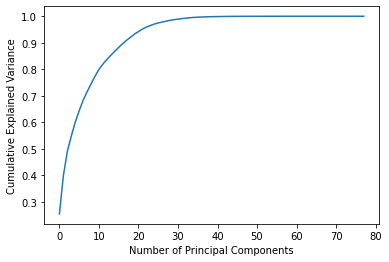

In [70]:
pca_test = PCA().fit(df_scaled)
plt.plot(np.cumsum(pca_test.explained_variance_ratio_))
plt.xlabel('Number of Principal Components')
plt.ylabel('Cumulative Explained Variance')
plt.show()

**This Scree plot shows the variance explained by each principal component within the un-normalised dataset.**

Therefore, using the un-normalised dataset for PCA, only around 5 to 7 principal components are needed to explain the entire (99.9...%) variation of the original dataset. This is a very large dimension reduction.

Thus, looking at the Environment Variables (at the top of the notebook), the 'dimensions_num_for_PCA' variable will be set to between 5 and 7 based upon this evidence, to maximise efficiency and also dataset accuracy (after PCA). If the non-normalised dataset is being used, of course.

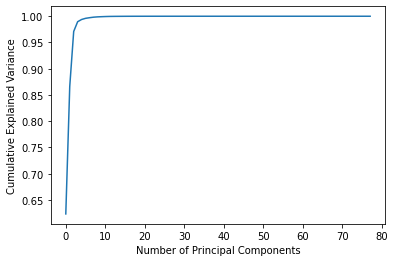

In [71]:
# The df_no_labels dataset holds the un-normalised dataset.
pca_test = PCA().fit(df_no_labels)
plt.plot(np.cumsum(pca_test.explained_variance_ratio_))
plt.xlabel('Number of Principal Components')
plt.ylabel('Cumulative Explained Variance')
plt.show()

### Important note on these above scree plot results

***The results of these graphs can change/ vary between different datasets used. Thus, these need to be inspected each time a new dataset (.csv file) is to be run on this code. Then, using the information the plots show, one should alter the environment variables.***

## Now fitting and transforming the data with PCA

In [72]:
pca = PCA(n_components=dimensions_num_for_PCA)
#principal_components = pca.fit(df_scaled).transform(df_scaled) => for normalised PCA

# Non-normalised PCA
principal_components = pca.fit(df_no_labels).transform(df_no_labels)
principal_components

array([[-8.16580279e+06, -1.19915322e+06,  1.27263308e+05, ...,
         8.93600581e+05,  2.96811663e+05,  5.98234594e+03],
       [-8.08590567e+06, -1.19861324e+06,  9.21736216e+04, ...,
         8.99819189e+05,  2.96878115e+05,  5.81150453e+03],
       [-1.00194924e+07, -1.22629216e+06,  2.02487220e+05, ...,
        -2.15507753e+05, -5.82407941e+04, -3.75222176e+04],
       ...,
       [-9.77881129e+06,  1.20711384e+05,  1.08402286e+05, ...,
        -1.99889067e+05, -4.93926336e+04, -4.26804840e+04],
       [-9.80388112e+06, -4.42548507e+05,  1.21580327e+05, ...,
        -1.96639141e+05, -4.85337246e+04, -3.96503044e+04],
       [-9.72175186e+06, -6.79955648e+05,  1.08244069e+05, ...,
        -1.93449359e+05, -3.30418761e+04, -3.68706087e+04]])

### Getting Principal Component feature names, dynamically

In [73]:
# See Methods at the top of the notebook
principal_component_headings = get_PCA_feature_names(dimensions_num_for_PCA)

Turning the Principal Components back into a Pandas Dataframe, ready for concatting back with the label feature

In [74]:
df_pc = pd.DataFrame(data = principal_components, columns = principal_component_headings)
df_pc

,Principal component 1,Principal component 2,Principal component 3,Principal component 4,Principal component 5,Principal component 6,Principal component 7
0,-8.165803e+06,-1.199153e+06,127263.307756,231525.444244,893600.580534,296811.662984,5982.345935
1,-8.085906e+06,-1.198613e+06,92173.621578,222554.882115,899819.189254,296878.115459,5811.504529
2,-1.001949e+07,-1.226292e+06,202487.219507,-114026.034526,-215507.753418,-58240.794133,-37522.217603
3,-8.104574e+06,-1.198907e+06,114579.819424,232052.538819,886792.249240,309302.450961,6391.775131
4,-1.001953e+07,-1.226232e+06,202496.514118,-114079.976276,-215668.219754,-58255.708667,-37616.209415
...,...,...,...,...,...,...,...
286091,-9.702691e+06,-6.754558e+05,108811.962532,-113698.699726,-192210.876425,-27627.809010,-36484.272722
286092,-9.338204e+06,-9.387585e+05,107612.275294,-53678.418683,-166703.000669,86349.888528,-14930.171400
286093,-9.778811e+06,1.207114e+05,108402.286219,-123110.822316,-199889.066997,-49392.633591,-42680.484006
286094,-9.803881e+06,-4.425485e+05,121580.327254,-122251.188352,-196639.141355,-48533.724648,-39650.304436


### Joining/ concatinating the label feature back onto the pca transformed dataset.

In [75]:
df_final = pd.concat([df_pc, df_labels], axis = 1)
df_final

,Principal component 1,Principal component 2,Principal component 3,Principal component 4,Principal component 5,Principal component 6,Principal component 7,label
0,-8.165803e+06,-1.199153e+06,127263.307756,231525.444244,893600.580534,296811.662984,5982.345935,BENIGN
1,-8.085906e+06,-1.198613e+06,92173.621578,222554.882115,899819.189254,296878.115459,5811.504529,BENIGN
2,-1.001949e+07,-1.226292e+06,202487.219507,-114026.034526,-215507.753418,-58240.794133,-37522.217603,BENIGN
3,-8.104574e+06,-1.198907e+06,114579.819424,232052.538819,886792.249240,309302.450961,6391.775131,BENIGN
4,-1.001953e+07,-1.226232e+06,202496.514118,-114079.976276,-215668.219754,-58255.708667,-37616.209415,BENIGN
...,...,...,...,...,...,...,...,...
286091,-9.702691e+06,-6.754558e+05,108811.962532,-113698.699726,-192210.876425,-27627.809010,-36484.272722,BENIGN
286092,-9.338204e+06,-9.387585e+05,107612.275294,-53678.418683,-166703.000669,86349.888528,-14930.171400,BENIGN
286093,-9.778811e+06,1.207114e+05,108402.286219,-123110.822316,-199889.066997,-49392.633591,-42680.484006,BENIGN
286094,-9.803881e+06,-4.425485e+05,121580.327254,-122251.188352,-196639.141355,-48533.724648,-39650.304436,BENIGN


### Transforming the label feature's categorical data into numeric data (via LabelBinarizer)

In [76]:
lb = LabelBinarizer()
df_final['label'] = lb.fit_transform(df_final['label'])
df_final.sample(10)

,Principal component 1,Principal component 2,Principal component 3,Principal component 4,Principal component 5,Principal component 6,Principal component 7,label
1747,-9.958860e+06,-1.219817e+06,2.040695e+05,-1.064577e+05,-1.666720e+05,-4.322294e+04,-2.781177e+04,0
184596,-1.002119e+07,-1.079864e+06,2.023855e+05,-1.140109e+05,-2.155855e+05,-5.829354e+04,-3.758392e+04,1
149183,-1.002107e+07,-1.089850e+06,2.023915e+05,-1.140116e+05,-2.155792e+05,-5.828968e+04,-3.757873e+04,1
173543,-1.002127e+07,-1.072352e+06,2.023811e+05,-1.140103e+05,-2.155905e+05,-5.829661e+04,-3.758802e+04,1
257363,-1.003497e+07,2.068301e+05,2.016443e+05,-1.137108e+05,-2.149238e+05,-5.808595e+04,-3.743105e+04,0
235482,-1.002002e+07,-1.223978e+06,2.025143e+05,-1.141903e+05,-2.168335e+05,-5.891687e+04,-3.834698e+04,0
98125,-1.002132e+07,-1.066230e+06,2.023792e+05,-1.140084e+05,-2.155630e+05,-5.827219e+04,-3.756792e+04,1
143866,-1.002015e+07,-1.167031e+06,2.024487e+05,-1.140164e+05,-2.155050e+05,-5.824229e+04,-3.752688e+04,1
71348,-1.003536e+07,2.373302e+05,2.016208e+05,-1.137267e+05,-2.149705e+05,-5.808869e+04,-3.744119e+04,0
260166,1.130961e+08,9.302241e+04,-3.608687e+07,-2.353178e+06,-1.443548e+06,-2.896977e+06,-1.797477e+06,0


In [77]:
print("Before LabelBinarizer: ", df_labels.unique())
print("After LabelBinarizer: ", df_final['label'].unique())

Before LabelBinarizer:  ['BENIGN' 'PortScan']
After LabelBinarizer:  [0 1]


##### The data is now fully cleaned and transformed, ready for pre-modeling test_train data splitting

### K-Fold Cross Validation and Stratified splitting

In [78]:
# Separating the label so that the answers aren't provided to the model, in training.
X = df_final.drop(['label'], axis = 1)
y = df_final['label']
y

0         0
1         0
2         0
3         0
4         0
         ..
286091    0
286092    0
286093    0
286094    0
286095    0
Name: label, Length: 286096, dtype: int32

### Initialising the StratifiedKFold model

In [79]:
skf = StratifiedKFold(n_splits=num_of_splits_for_skf, shuffle=False)
skf

StratifiedKFold(n_splits=10, random_state=None, shuffle=False)

Now, splitting the data into train and test data, using the optimal splitting techniques of K-Fold and Stratified Splitting.

In [80]:
for train_index, test_index in skf.split(X, y):
    X_train, X_test = X.iloc[train_index], X.iloc[test_index]
    y_train, y_test = y.iloc[train_index], y.iloc[test_index]

    reshaped_y_train = np.asarray(y_train).reshape(-1, 1)
    reshaped_y_test = np.asarray(y_test).reshape(-1, 1)
    
print( 'X_train length: ', len(X_train) ) # To check if splits worked
print( 'y_train length: ', len(y_train) )
print( 'X_test length: ', len(X_test) )
print( 'y_test length: ', len(y_test) )

X_train length:  257487
y_train length:  257487
X_test length:  28609
y_test length:  28609


# Modeling stage

#### Data is now fully transformed and ready for ML model training and predictions.

### K-Nearest neighbor ML classifier
The KNN algorithm assumes that similar things exist in close proximity. In other words, similar things are assumed to be near to each other.

In [81]:
knn_model = KNeighborsClassifier(n_neighbors=5, weights='uniform',
                                    algorithm='auto', leaf_size=30,
                                    p=2, metric='minkowski',
                                    metric_params=None, n_jobs=None)

### Training the model and predicting test data results (confusion matrix)

Classification report: 
               precision    recall  f1-score   support

           0       1.00      1.00      1.00     12729
           1       1.00      1.00      1.00     15880

    accuracy                           1.00     28609
   macro avg       1.00      1.00      1.00     28609
weighted avg       1.00      1.00      1.00     28609
 

Model accuracy=  99.65395504911042 %

Dataset labels:  ['BENIGN' 'PortScan']
Dataset numeric labels after encoding for model:  [0 1]


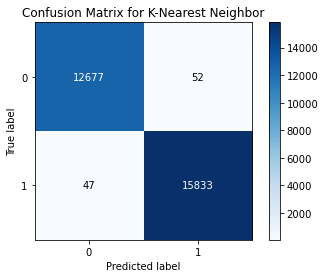

In [82]:
# Unpacking the method return values. Last 4 are needed for statistical distance measure methods.
accuracy, X_train, X_test, y_train, pred_y = train_model_predict(knn_model, "K-Nearest Neighbor", X, y, skf)
print("Model accuracy= ", accuracy*100, "%\n")
print("Dataset labels: ", df_labels.unique())
print("Dataset numeric labels after encoding for model: ", df_final['label'].unique())

In [83]:
# import pickle
# pkl_model = "knn_model.pkl"
# with open(pkl_model, 'wb') as file:
#     pickle.dump(knn_model, file)

# # Load from file
# with open(pkl_model, 'rb') as file:
#     knn_model = pickle.load(file)
    
# score = knn_model.score(X_test, y_test)
# print("Test score: {0:.2f} %".format(100 * score))

In [84]:
#models
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier

# Put our models in a dictionary
models = {"Logistic Regression": LogisticRegression(),
          "Random Forest": RandomForestClassifier()}

# Create a function to fit and score models
def fit_and_score(models, X_train, X_test, y_train, y_test):
    """
    Fits and evaluates given machine learning models.
    models : a dict of differetn Scikit-Learn machine learning models
    X_train : training data (no labels)
    X_test : testing data (no labels)
    y_train : training labels
    y_test : test labels
    """
    # Set random seed
    np.random.seed(10)
    # Make dictionnary to keep model scores
    model_scores = {}
    # Let's loop through models to find the best
    for name, model in models.items():
        model.fit(X_train, y_train)
        
        # evaluating the model
        model_scores[name] = model.score(X_test, y_test)
        
    return model_scores

In [85]:
model_scores = fit_and_score(models=models, X_train=X_train, X_test=X_test, y_train=y_train, y_test=y_test)

model_scores

{'Logistic Regression': 0.6847845083714915, 'Random Forest': 0.99804257401517}

In [86]:
clf=RandomForestClassifier(n_estimators=100)

RF_model = clf.fit(X_train, y_train)

score = RF_model.score(X_test, y_test)
print("Test score: {0:.2f} %".format(100 * score))

Test score: 99.79 %


In [87]:
# Make predictions with tuned model
y_preds = RF_model.predict(X_test)
y_preds

array([1, 1, 1, ..., 0, 0, 0])

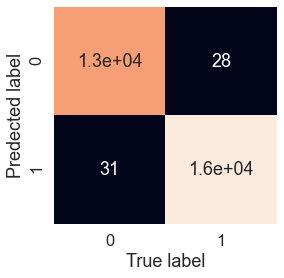

In [89]:
sns.set(font_scale=1.5)
from sklearn.metrics import confusion_matrix, classification_report

def plot_conf_mat(y_test, y_preds):
    """
    Plot a nice looking confusion matrix using seaborn's heatmap() 
    """
    
    fig, ax = plt.subplots(figsize=(4,4))
    ax = sns.heatmap(confusion_matrix(y_test, y_preds), 
                     annot=True,
                     cbar=False)
    plt.xlabel("True label")
    plt.ylabel("Predected label")
    
plot_conf_mat(y_test, y_preds)

In [34]:
X_test.sample(5)

,Principal component 1,Principal component 2,Principal component 3,Principal component 4,Principal component 5,Principal component 6,Principal component 7
252266,-1.002224e+07,-9.837564e+05,202329.034025,-113997.227972,-215577.766485,-58285.420976,-37588.801582
283710,-1.003364e+07,8.057756e+04,201716.387489,-113749.467159,-215006.686699,-58101.520282,-37445.219645
269885,-1.002119e+07,-1.078089e+06,202386.652343,-114010.002998,-215560.528326,-58270.261055,-37564.889781
278335,-1.002162e+07,-1.040167e+06,202363.276678,-114005.349170,-215570.859338,-58277.843056,-37576.210115
269623,-1.002072e+07,-1.119595e+06,202413.478337,-114014.525218,-215545.248090,-58260.883563,-37551.305898


In [35]:
y_test[268774]

1

In [42]:
# import pickle
# pkl_model = "RF_model.xml"
# with open(pkl_model, 'wb') as file:
#     pickle.dump(RF_model, file)

# # Load from file
# with open(pkl_model, 'rb') as file:
#     RF_model = pickle.load(file)
    
# score = RF_model.score(X_test, y_test)
# print("Test score: {0:.2f} %".format(100 * score))

Test score: 99.79 %


In [37]:
# !pip install micromlgen

In [39]:
# from micromlgen import port
# Gen_model = "Gen_model.cpp"

# with open(Gen_model, 'w') as file:
#     file.write(port(RF_model))
